This notebook briefly walks through fitting the four linear Bayesian regression calibrations for global core top $\delta^{18}\mathrm{O}_{\mathrm{c}}$ and SSTs.

Notebook settings for graphics and load some libraries.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm

Set paths to our core top data. These are also given as supplemental information in the paper.

In [3]:
coretop_path = '../data/parsed/coretops.csv'
coretop_grid_path = '../data/parsed/coretops_grid.csv'

# Read coretop data and parse

This should be straightforward.

In [4]:
coretops_raw = pd.read_csv(coretop_path)
coretops_grid = pd.read_csv(coretop_grid_path)

In [5]:
coretops_raw['foramtype'] = coretops_raw['species'].astype('category')
coretops_grid['foramtype'] = coretops_grid['species'].astype('category')

Take a quick look at the data to see what we're dealing with... (and make sure everything is there)

In [6]:
coretops_raw['foramtype'].unique()

[G. bulloides, G. ruber, N. incompta, N. pachyderma, T. sacculifer]
Categories (5, object): [G. bulloides, G. ruber, N. incompta, N. pachyderma, T. sacculifer]

In [7]:
coretops_raw['foramtype'].value_counts()

G. ruber         1002
G. bulloides      635
T. sacculifer     442
N. pachyderma     425
N. incompta       132
Name: foramtype, dtype: int64

In [8]:
coretops_grid.head()

,species,gridlat,gridlon,d18oc,d18osw,t_annual,t_seasonal,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,foramtype
0,G. bulloides,-57.5,-53.5,2.240000,-0.297468,2.100175,3.783593,1,1,1,0,0,0,0,0,0,0,0,0,G. bulloides
1,G. bulloides,-56.5,-115.5,2.280000,-0.292819,5.167257,5.167257,1,1,1,1,1,1,1,1,1,1,1,1,G. bulloides
2,G. bulloides,-56.5,-56.5,2.245000,-0.281994,3.576477,4.666713,1,1,1,1,1,0,0,0,0,0,0,1,G. bulloides
3,G. bulloides,-55.5,-58.5,2.146000,-0.272228,4.832495,4.983686,1,1,1,1,1,1,1,1,0,1,1,1,G. bulloides
4,G. bulloides,-55.5,-57.5,2.348571,-0.266258,4.671475,5.106034,1,1,1,1,1,1,0,1,0,0,1,1,G. bulloides


# MCMC models

## Annual SST pooled model

This is the model setup that pools all foram species together and calibrates on annual-mean SSTs.

Models is:
\begin{align}
\delta^{18}O_c = \alpha + \beta * T + \delta^{18}O_{sw} - 0.27 + \epsilon \\
\end{align}

with parameters:
\begin{align}
\alpha \sim \mathcal{N}(3, 4) \\
\beta \sim \mathcal{N}(-0.2, 1) \\
\epsilon \sim \mathcal{N}(0, \tau) \\
\tau \sim \mathrm{HalfCauchy}(1)
\end{align}


Copy the original `coretops_grid` to `coretops`, which is our working copy. Then we make a `temp` column from the annual SST data.

In [9]:
coretops = coretops_grid.copy()
coretops['temp'] = coretops['t_annual']

This gives you an idea what the data looks like:

In [10]:
print(coretops.shape)
coretops.head()

(1386, 21)


,species,gridlat,gridlon,d18oc,d18osw,t_annual,t_seasonal,m1,m2,m3,...,m5,m6,m7,m8,m9,m10,m11,m12,foramtype,temp
0,G. bulloides,-57.5,-53.5,2.240000,-0.297468,2.100175,3.783593,1,1,1,...,0,0,0,0,0,0,0,0,G. bulloides,2.100175
1,G. bulloides,-56.5,-115.5,2.280000,-0.292819,5.167257,5.167257,1,1,1,...,1,1,1,1,1,1,1,1,G. bulloides,5.167257
2,G. bulloides,-56.5,-56.5,2.245000,-0.281994,3.576477,4.666713,1,1,1,...,1,0,0,0,0,0,0,1,G. bulloides,3.576477
3,G. bulloides,-55.5,-58.5,2.146000,-0.272228,4.832495,4.983686,1,1,1,...,1,1,1,1,0,1,1,1,G. bulloides,4.832495
4,G. bulloides,-55.5,-57.5,2.348571,-0.266258,4.671475,5.106034,1,1,1,...,1,1,0,1,0,0,1,1,G. bulloides,4.671475


This is the number of gridpoints we have for each foram species.

In [11]:
coretops.foramtype.value_counts()

G. ruber         489
G. bulloides     291
N. pachyderma    273
T. sacculifer    243
N. incompta       90
Name: foramtype, dtype: int64

Now define the model and sample it.

In [12]:
temp = coretops['temp'].values
d18osw = coretops['d18osw'].values
d18oc = coretops['d18oc'].values

with pm.Model() as model:
    # Intercept and slope
    a = pm.Normal('a', mu=3.0, sd=2)
    b = pm.Normal('b', mu=-0.2, sd=1)

    # Model error
    tau = pm.HalfCauchy('tau', beta=1)

    # Likelihood
    d18oc_est = a + b * temp + (d18osw - 0.27)
    likelihood_d18oc = pm.Normal('likelihood_d18oc', mu=d18oc_est, sd=tau,
                                 observed=d18oc)
    trace = pm.sample(draws=5000, tune=1000, chains=2, init='jitter+adapt_diag', random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, b, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:14<00:00, 822.13draws/s] 


Very basic diagnostic plots showing the sampling and posterior distribution of the parameters. Remember that the trace plot (below) has two lines on each plot, one for each chain.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bfed0da58>,
      dtype=object)

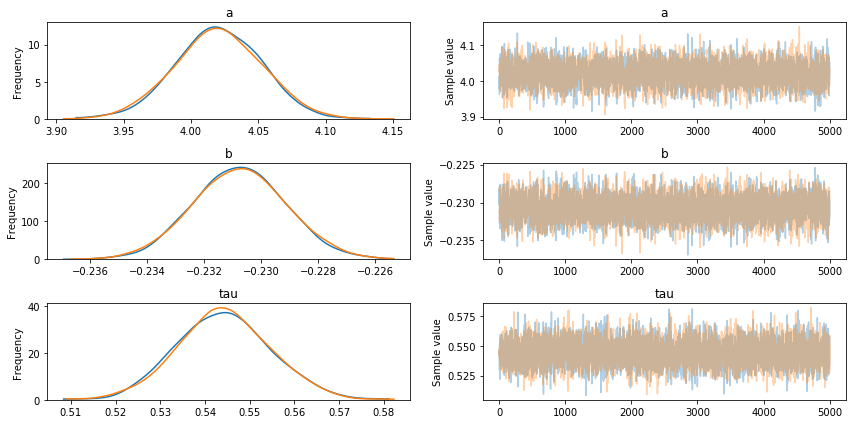

In [13]:
pm.plots.traceplot(trace)

GridSpec(1, 2, width_ratios=[3, 1])

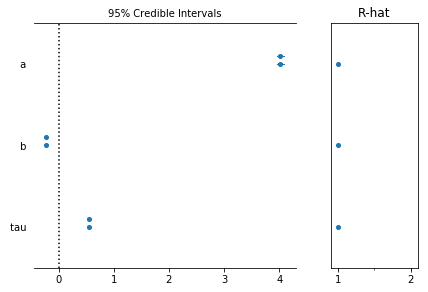

In [14]:
pm.plots.forestplot(trace)

Here is our PSIS-LOO statistics, for cross-validation.

In [15]:
pm.stats.loo(trace, model)

LOO_r(LOO=2248.330012450686, LOO_se=74.15124124931084, p_LOO=3.6165249073924315, shape_warn=0)

## Seasonal SST pooled model

Same deal as before. This is a model setup that pools all foram species together but calibrates against the seasonal SSTs instead of annual.

Models is:
\begin{align}
\delta^{18}O_c = \alpha + \beta * T + \delta^{18}O_{sw} - 0.27 + \epsilon \\
\end{align}

with parameters:
\begin{align}
\alpha \sim \mathcal{N}(3, 4) \\
\beta \sim \mathcal{N}(-0.2, 1) \\
\epsilon \sim \mathcal{N}(0, \tau) \\
\tau \sim \mathrm{HalfCauchy}(1)
\end{align}


In [16]:
coretops = coretops_grid.copy()
coretops['temp'] = coretops['t_seasonal']

In [17]:
print(coretops.shape)
coretops.head()

(1386, 21)


,species,gridlat,gridlon,d18oc,d18osw,t_annual,t_seasonal,m1,m2,m3,...,m5,m6,m7,m8,m9,m10,m11,m12,foramtype,temp
0,G. bulloides,-57.5,-53.5,2.240000,-0.297468,2.100175,3.783593,1,1,1,...,0,0,0,0,0,0,0,0,G. bulloides,3.783593
1,G. bulloides,-56.5,-115.5,2.280000,-0.292819,5.167257,5.167257,1,1,1,...,1,1,1,1,1,1,1,1,G. bulloides,5.167257
2,G. bulloides,-56.5,-56.5,2.245000,-0.281994,3.576477,4.666713,1,1,1,...,1,0,0,0,0,0,0,1,G. bulloides,4.666713
3,G. bulloides,-55.5,-58.5,2.146000,-0.272228,4.832495,4.983686,1,1,1,...,1,1,1,1,0,1,1,1,G. bulloides,4.983686
4,G. bulloides,-55.5,-57.5,2.348571,-0.266258,4.671475,5.106034,1,1,1,...,1,1,0,1,0,0,1,1,G. bulloides,5.106034


Now define the model and sample...

In [18]:
temp = coretops['temp'].values
d18osw = coretops['d18osw'].values
d18oc = coretops['d18oc'].values

with pm.Model() as model:
    # Intercept and slope
    a = pm.Normal('a', mu=3.0, sd=2)
    b = pm.Normal('b', mu=-0.2, sd=1)

    # Model error
    tau = pm.HalfCauchy('tau', beta=1)

    # Likelihood
    d18oc_est = a + b * temp + (d18osw - 0.27)
    likelihood_d18oc = pm.Normal('likelihood_d18oc', mu=d18oc_est, sd=tau,
                                 observed=d18oc)
    trace = pm.sample(draws=5000, tune=1000, chains=2, init='jitter+adapt_diag', random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, b, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:13<00:00, 859.43draws/s] 


Diagnostic plots...

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bfc78f4e0>,
      dtype=object)

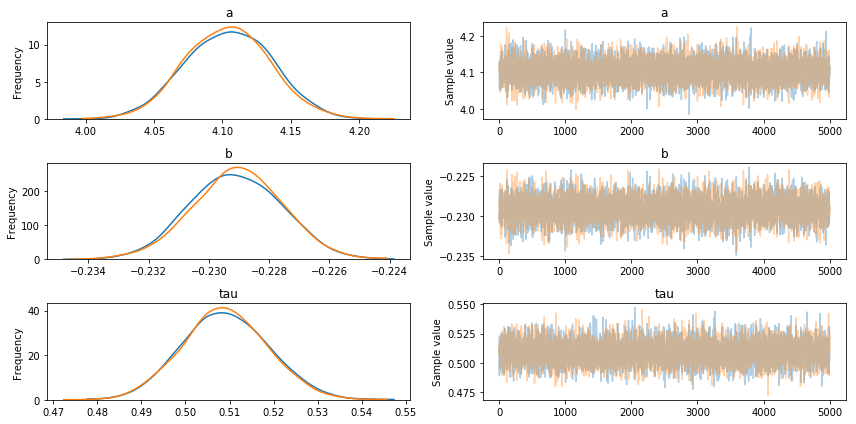

In [19]:
pm.plots.traceplot(trace)

GridSpec(1, 2, width_ratios=[3, 1])

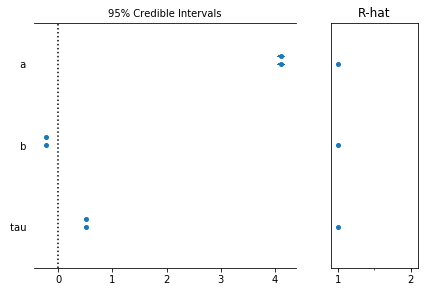

In [20]:
pm.plots.forestplot(trace)

PSIS-LOO, the cross-validation statistic:

In [21]:
pm.stats.loo(trace, model)

LOO_r(LOO=2063.3352538660483, LOO_se=65.1643759424864, p_LOO=3.268363037828749, shape_warn=0)

## Annual SST hierarchical model

This is the hierarchical model setup, calibrated on annual SSTs. We're allowing some wiggle room in the parameters, for the individual species.

Models is:
\begin{align}
\delta^{18}O_c = \alpha_i + \beta_i * T + \delta^{18}O_{sw} - 0.27 + \epsilon \\
\end{align}

using parameters set for individual foram species ($i$):
\begin{align}
\epsilon \sim \mathcal{N}(0, \tau_i) \\
\alpha_i \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\beta_i \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\tau_i \sim \mathrm{\Gamma}( \frac{\sigma_m^2} {\sigma_d^2}, \frac{\sigma_m} {\sigma_d^2} ) \\
\end{align}

and hyperparameters:
\begin{align}
\mu_\alpha \sim \mathcal{N}(3, 4) \\
\mu_\beta \sim \mathcal{N}(-0.2, 1) \\
\sigma_\alpha \sim \mathrm{HalfCauchy}(0.5) \\
\sigma_\beta \sim \mathrm{HalfCauchy}(0.25) \\
\sigma_m \sim \mathrm{HalfCauchy}(1) \\
\sigma_d \sim \mathrm{HalfCauchy}(1) \\
\end{align}



The rest follows what we had before.

Let's make a new copy of the core top data and set `temp`:

In [22]:
coretops = coretops_grid.copy()
coretops['temp'] = coretops['t_annual']

Define the model and sample from it...

In [23]:
temp = coretops['temp'].values
d18osw = coretops['d18osw'].values
d18oc = coretops['d18oc'].values
foramtype = coretops['foramtype'].cat.codes
n_foram = len(set(foramtype))


with pm.Model() as model:
    # Hyperparameters
    mu_a = pm.Normal('mu_a', mu=3, sd=2)
    sigma_a = pm.HalfCauchy('sigma_a', beta=0.5)

    mu_b = pm.Normal('mu_b', mu=-0.2, sd=1)
    sigma_b = pm.HalfCauchy('sigma_b', beta=0.25)

    sigma_m = pm.HalfCauchy('sigma_m', beta=1)
    sigma_d = pm.HalfCauchy('sigma_d', beta=1)

    # Intercept and slope
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_foram)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_foram)

    # Model error
    tau = pm.Gamma('tau', alpha=sigma_m**2 / sigma_d**2,
                          beta=sigma_m / sigma_d**2,
                          shape=n_foram)

    # Likelihood
    d18oc_est = a[foramtype] + b[foramtype] * temp + (d18osw - 0.27)
    likelihood_d18oc = pm.Normal('likelihood_d18oc', mu=d18oc_est, 
                                 sd=tau[foramtype], observed=d18oc)
    trace = pm.sample(draws=5000, tune=1000, chains=2, init='jitter+adapt_diag', random_seed=123)

/home/sbm/miniconda3/envs/d18oc_sst/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sbm/miniconda3/envs/d18oc_sst/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, b, a, sigma_d, sigma_m, sigma_b, mu_b, sigma_

Diagnostic plots and such... same as before.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2be6e4fb70>,
      dtype=object)

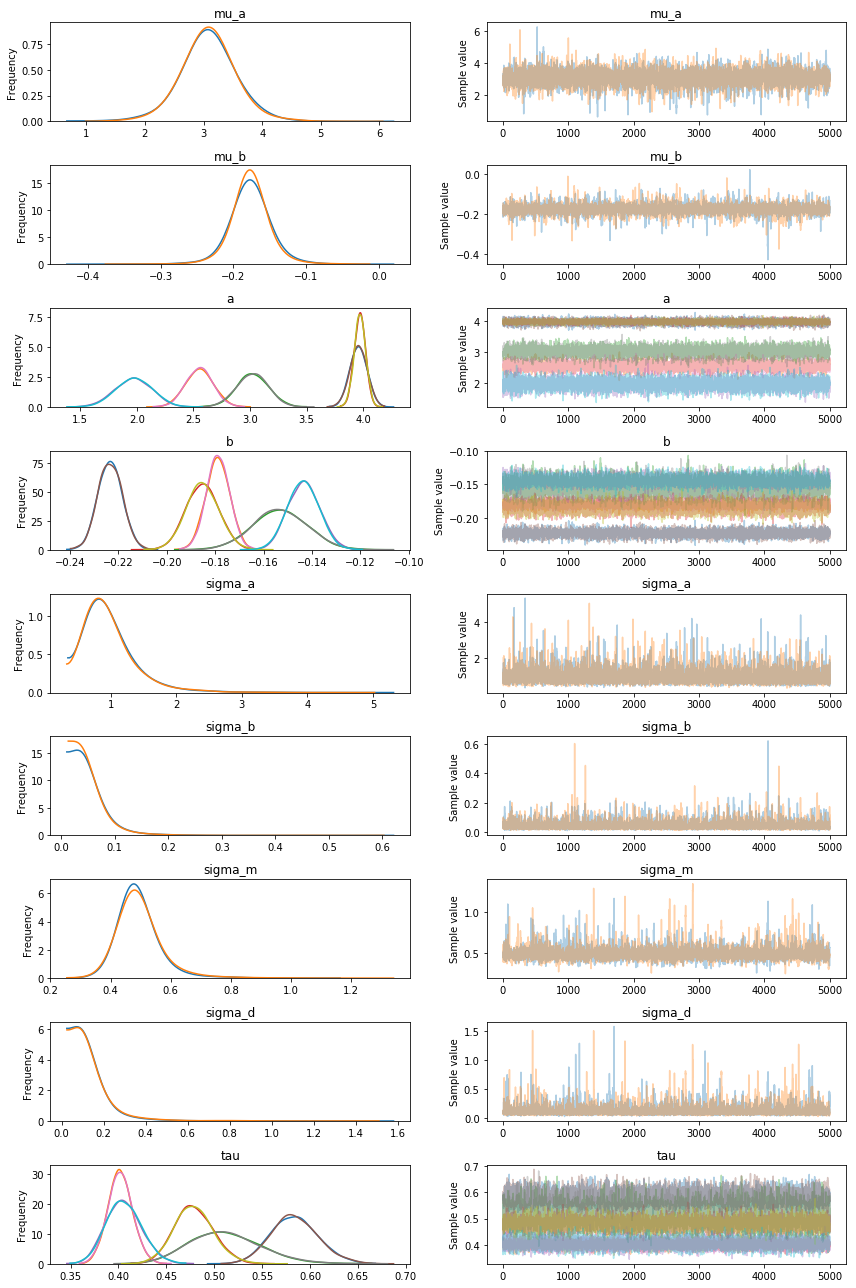

In [24]:
pm.plots.traceplot(trace)

GridSpec(1, 2, width_ratios=[3, 1])

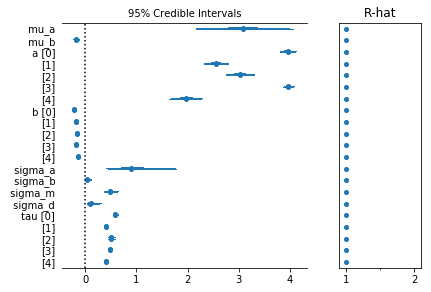

In [25]:
pm.plots.forestplot(trace)

...and the PSIS-LOO cross-validation statistic:

In [26]:
pm.stats.loo(trace, model)

/home/sbm/miniconda3/envs/d18oc_sst/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


LOO_r(LOO=1783.1659029713364, LOO_se=68.30307163243374, p_LOO=18.424742754624276, shape_warn=0)

## Seasonal SST hierarchical model

Here we use the same hierarchical model setup, but calibrated on seasonal SSTs.

Models is:
\begin{align}
\delta^{18}O_c = \alpha_i + \beta_i * T + \delta^{18}O_{sw} - 0.27 + \epsilon \\
\end{align}

using parameters set for individual foram species ($i$):
\begin{align}
\epsilon \sim \mathcal{N}(0, \tau_i) \\
\alpha_i \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\beta_i \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\tau_i \sim \mathrm{\Gamma}( \frac{\sigma_m^2} {\sigma_d^2}, \frac{\sigma_m} {\sigma_d^2} ) \\
\end{align}

and hyperparameters:
\begin{align}
\mu_\alpha \sim \mathcal{N}(3, 4) \\
\mu_\beta \sim \mathcal{N}(-0.2, 1) \\
\sigma_\alpha \sim \mathrm{HalfCauchy}(0.5) \\
\sigma_\beta \sim \mathrm{HalfCauchy}(0.25) \\
\sigma_m \sim \mathrm{HalfCauchy}(1) \\
\sigma_d \sim \mathrm{HalfCauchy}(1) \\
\end{align}



In [27]:
coretops = coretops_grid.copy()
coretops['temp'] = coretops['t_seasonal']

Fit the model and sample it...

In [28]:
temp = coretops['temp'].values
d18osw = coretops['d18osw'].values
d18oc = coretops['d18oc'].values
foramtype = coretops['foramtype'].cat.codes
n_foram = len(set(foramtype))


with pm.Model() as model:
    # Hyperparameters
    mu_a = pm.Normal('mu_a', mu=3, sd=2)
    sigma_a = pm.HalfCauchy('sigma_a', beta=0.5)

    mu_b = pm.Normal('mu_b', mu=-0.2, sd=1)
    sigma_b = pm.HalfCauchy('sigma_b', beta=0.25)

    sigma_m = pm.HalfCauchy('sigma_m', beta=1)
    sigma_d = pm.HalfCauchy('sigma_d', beta=1)

    # Intercept and slope
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_foram)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_foram)

    # Model error
    tau = pm.Gamma('tau', alpha=sigma_m**2 / sigma_d**2,
                          beta=sigma_m / sigma_d**2,
                          shape=n_foram)

    # Likelihood
    d18oc_est = a[foramtype] + b[foramtype] * temp + (d18osw - 0.27)
    likelihood_d18oc = pm.Normal('likelihood_d18oc', mu=d18oc_est, 
                                 sd=tau[foramtype], observed=d18oc)
    trace = pm.sample(draws=5000, tune=1000, chains=2, init='jitter+adapt_diag', random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, b, a, sigma_d, sigma_m, sigma_b, mu_b, sigma_a, mu_a]
Sampling 2 chains: 100%|██████████| 12000/12000 [04:22<00:00, 26.80draws/s]
The number of effective samples is smaller than 25% for some parameters.


Diagnostics...

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c025db5c0>,
      dtype=object)

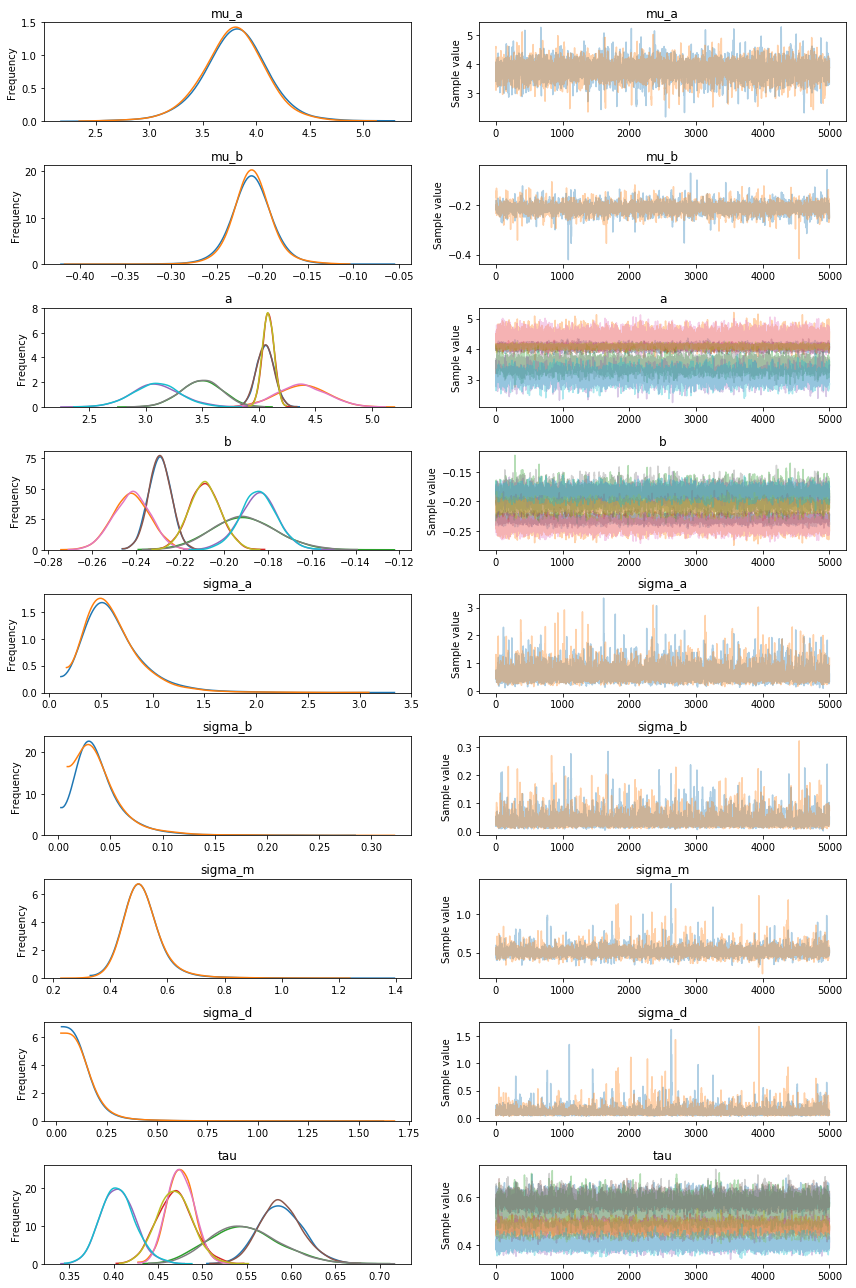

In [29]:
pm.plots.traceplot(trace)

GridSpec(1, 2, width_ratios=[3, 1])

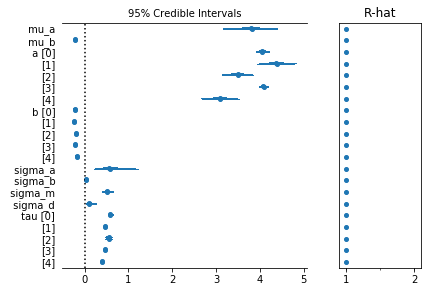

In [30]:
pm.plots.forestplot(trace)

And our PSIS-LOO cross-validation statistic...

In [31]:
pm.stats.loo(trace, model)

LOO_r(LOO=1952.2478024964116, LOO_se=65.8857575929775, p_LOO=17.875933673433337, shape_warn=0)